In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt

import pppc
from pppc.configs import PtychoNNTrainingConfigDict
from pppc.ptychonn.trainer import PtychoNNTrainer
from pppc.ptychonn.dataset_handle import HDF5Dataset
from pppc.ptychonn.model import PtychoNNModel, PtychoNNTransposedConvModel, PtychoNNPhaseOnlyModel
from pppc.helper import transform_data_for_ptychonn

[2024-02-12 16:04:12,897] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-02-12 16:04:12,898] NumExpr defaulting to 8 threads.


Define some data transform functions for handling raw training data with different sizes. 

In [3]:
# Raw DP size 512, label 128; crop DPs to 384, then rescale to 128. (use default function in HDF5Dataset)
transform_func_512_128 = None
transform_func_kwargs_512_128 = None

# Raw DP size 512, label 128; crop DPs to 256, then pad to 384, and rescale to 128. (use default function in HDF5Dataset)
def transform_func_512_128_pad(dp):
    dp = transform_data_for_ptychonn(dp, target_shape=(256, 256), discard_len=(128, 128))
    dp = transform_data_for_ptychonn(dp, target_shape=(128, 128), discard_len=(-64, -64))
    return dp
transform_func_kwargs_512_128_pad = None

In [4]:
dataset = HDF5Dataset('data/data_train_meanSubStdData.h5', verbose=False, transform_func=None, transform_func_kwargs=None, standardized=True)

config_dict = PtychoNNTrainingConfigDict(
    batch_size_per_process=64,
    num_epochs=60,
    learning_rate_per_process=1e-4,
    optimizer='adam',
    model_save_dir='../../trained_models/model_phaseOnly_BN_36SpiralDatasets_meanSubStdData_cleaned_valRatio_10',
    validation_ratio=0.1,
    dataset=dataset,
    model=(PtychoNNPhaseOnlyModel, {'use_batchnorm': True}),
    debug=False
)

Check some data distributions. 

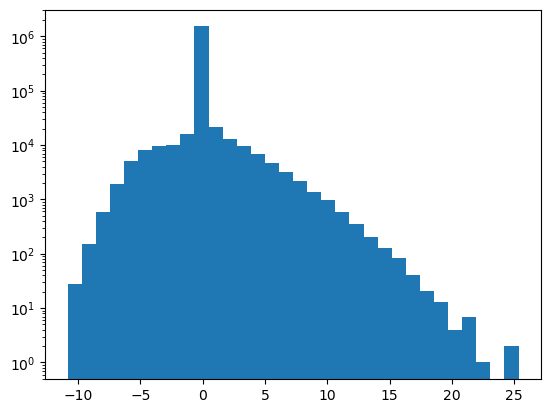

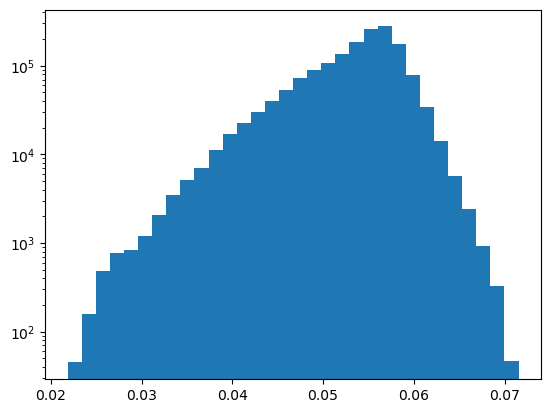

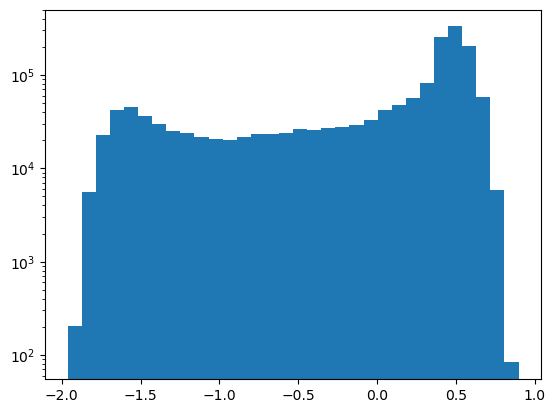

/tmp/ipykernel_1871016/2980939227.py:12: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(x[0, 0, :, :] + 1e-6))


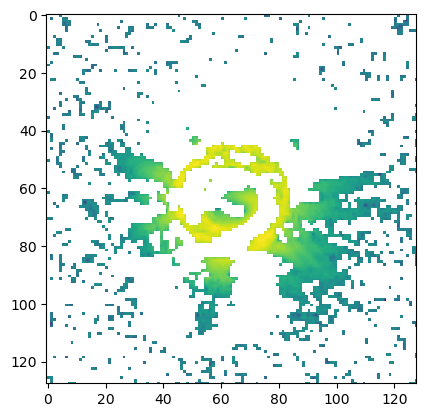

In [5]:
def plot_distribution(x):
    x = x.reshape(-1)
    #x = x[x > 0]
    plt.hist(x, bins=32)
    plt.semilogy()
    plt.show()

x, y_mag, y_ph = dataset.__getitems__(list(range(100)))
plot_distribution(x.numpy())
plot_distribution(y_mag.numpy())
plot_distribution(y_ph.numpy())
plt.imshow(np.log10(x[0, 0, :, :] + 1e-6))
plt.show()

In [6]:
trainer = PtychoNNTrainer(config_dict)
trainer.build(seed=196)

[2024-02-12 16:04:17,461] Using DataParallel with 2 devices.


In [7]:
trainer.run_training()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [01:29<00:00,  2.72it/s]
[2024-02-12 16:05:54,644] Saving improved model after Val Loss improved from inf to 0.44735
[2024-02-12 16:05:54,699] Epoch: 0 | FT  | Train Loss: 0.55537 | Val Loss: 0.44735
[2024-02-12 16:05:54,700] Epoch: 0 | Amp | Train Loss: 0.0000 | Val Loss: 0.0000
[2024-02-12 16:05:54,700] Epoch: 0 | Ph  | Train Loss: 0.555 | Val Loss: 0.447
[2024-02-12 16:05:54,701] Epoch: 0 | Ending LR: 0.000050 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [01:37<00:00,  2.51it/s]
[2024-02-12 16:07:36,924] Saving improved model after Val Loss improved from 0.44735 to 0.35369
[2024-02-12 16:07:37,012] Epoch: 1 | FT  | Train Loss: 0.38774 | Val Loss: 0.35369
[2024-02-12 16:07:37,014] Epoch: 1 | Amp | Train Loss: 0.0000 | Val Loss

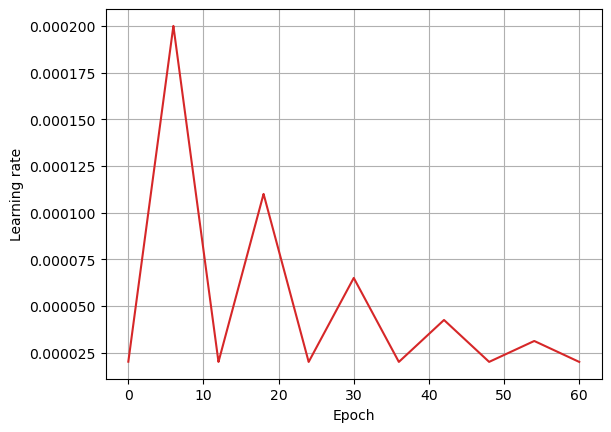

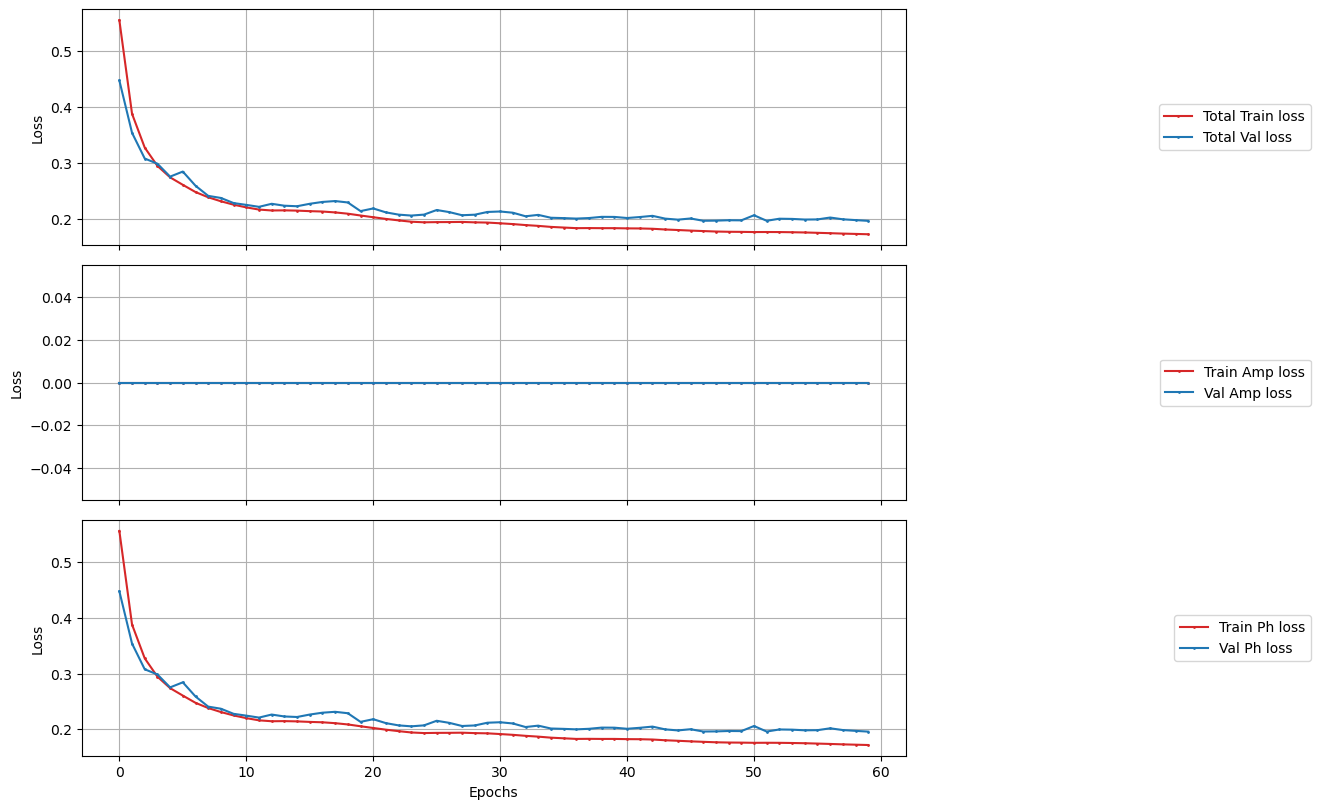

In [8]:
trainer.plot_training_history()

/data/programs/probe_position_correction_w_ptychonn/pppc/ptychonn/trainer.py:421: RuntimeWarning: invalid value encountered in log10
  self._plot_test_result(ax[0, i], np.log10(dp_list[i, 0, :, :] + 1))


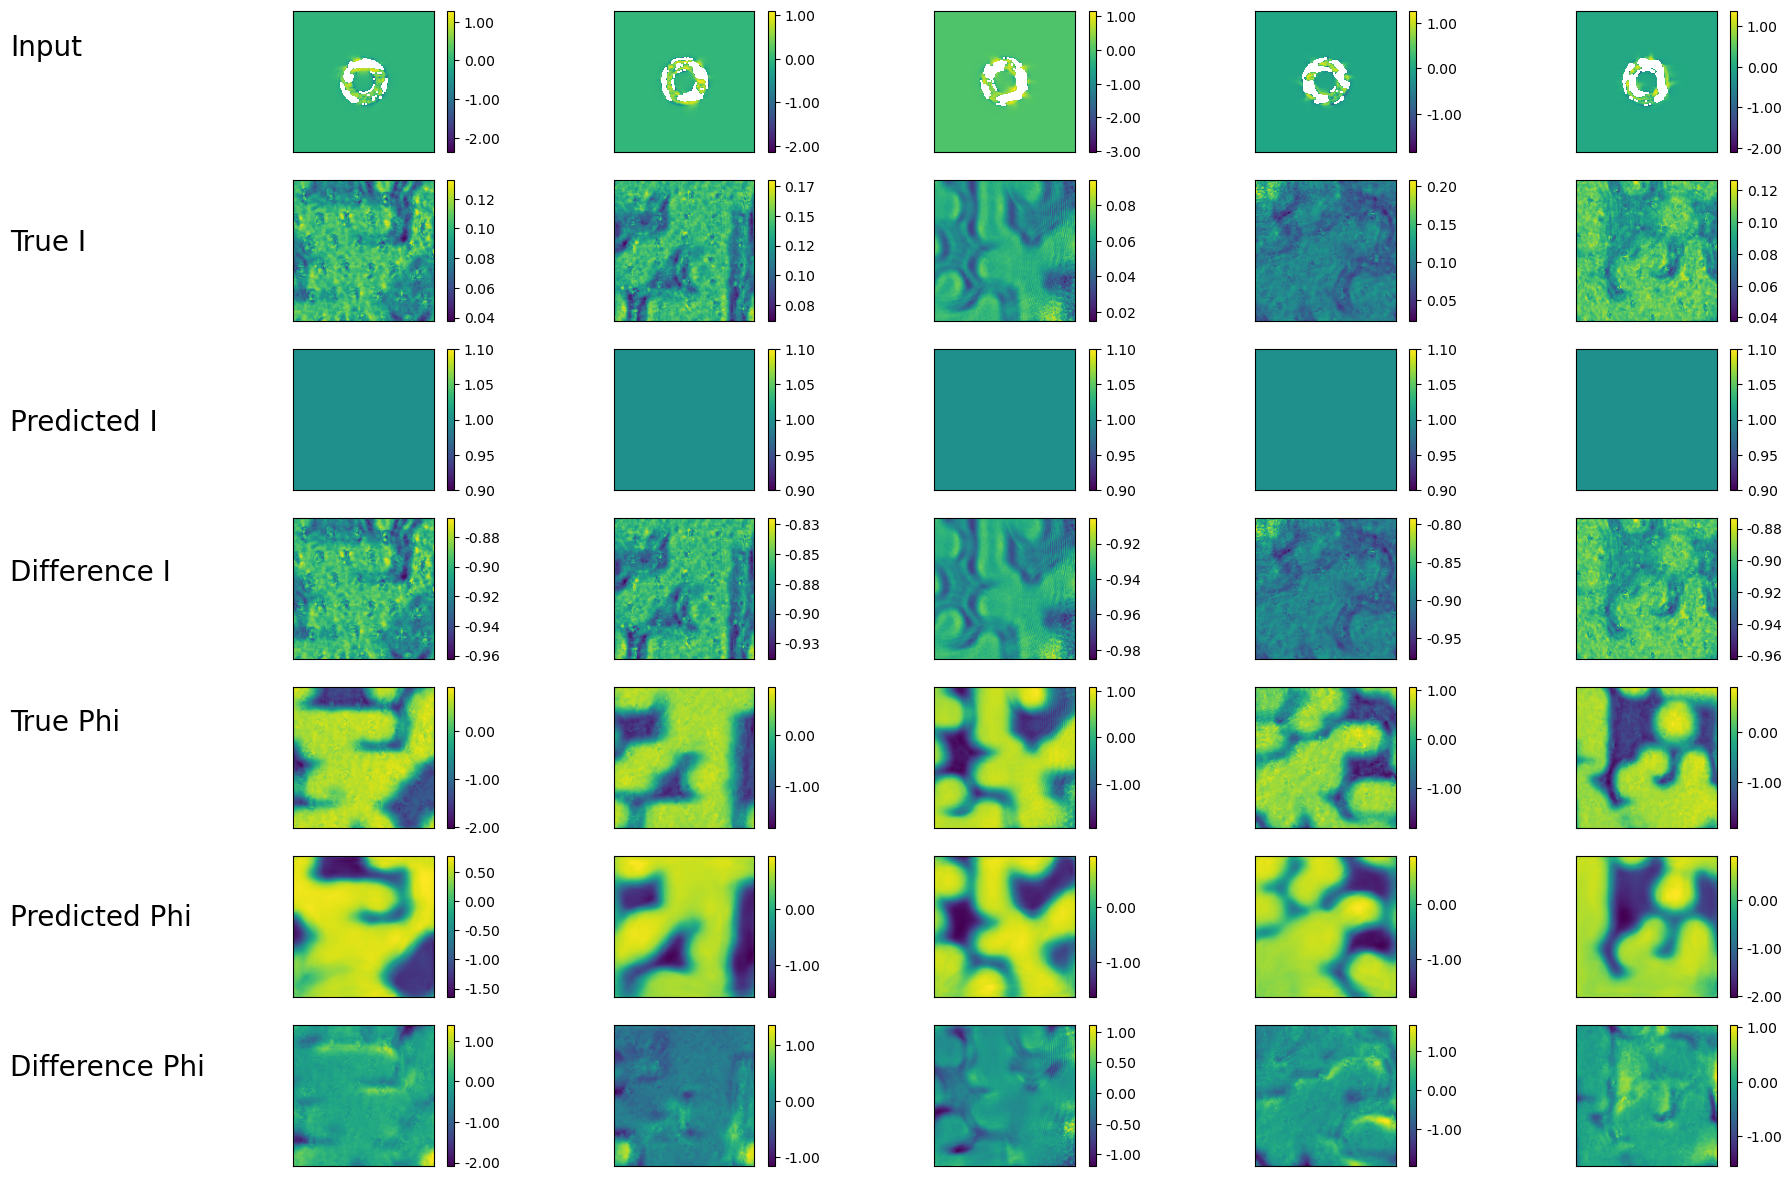

In [9]:
trainer.run_testing((0, 1000, 2000, 3000, 4000), dataset='train')